### **BPIC 2012 - No milestone**


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [3]:
milestone = 'All' #'A_PREACCEPTED' # 'W_Nabellen offertes', 'All'
subset = "W"
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
n_size = 5
max_size = 1000 #  3, 5, 10, 15, 20, 30, 50, 95
min_size = 0  # 0, 3, 5, 10, 15, 20, 30, 50

### Setting up the key parameters


In [5]:
# # For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [6]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)
args

{'folder': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\output_files',
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adam',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'n_size': 5,
 'file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\BPIC_2012_Prefixes.csv',
 'processed_file_name': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\BPIC_2012_Processed.csv',
 'file_name_all': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\BPIC_2012_Prefixes_all.csv',
 'processed_training_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\vec_training.p',
 'processed_test_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\vec_test.p',
 'processed_val_vec': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\vec_val.p',
 'weights': 'c:\\Users\\mithr\\Documents\\GitHub\\KBS-SI-Paper\\BPIC12\\All\\OHE\\weights.p',
 'indexes': 'c:\\U

In [7]:
#This code will be specific for all next activity prediction only, since we save the models and vectors by prefix length groups
# if milestone == 'All':
#   args['indexes'] = MILESTONE_DIR+'indexes_'+str(max_size)+'.p'
#   args['pre_index'] = MILESTONE_DIR+'pre_index_'+str(max_size)+'.p'
#   args['processed_test_vec'] = MILESTONE_DIR+'vec_test_'+str(max_size)+'.p'
#   args['processed_training_vec'] = MILESTONE_DIR+'vec_training_'+str(max_size)+'.p'
#   args['weights'] = MILESTONE_DIR+'weights_'+str(max_size)+'.p'

args['file_name_A_ex'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_A_ex.csv" )
args['file_name_O_ex'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_O_ex.csv" )
args['file_name_A_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_A_all.csv" )
args['file_name_O_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_O_all.csv" )
args['file_name_W_all'] = os.path.join(os.path.join(MY_WORKSPACE_DIR, "Translated_dataset"), "bpic12_translated_completed_W_all.csv" )

###Data Preprocessing

In [8]:

log_df = pd.read_csv(args['file_name_W_all'])
log_df = log_df.reset_index(drop=True)


log_df.head()

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length
0,173736_6,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Calling to add missing information to the ap...,W_Assessing the application,6,1,6
1,173736_4,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Calling after sent offers,W_Calling after sent offers,4,1,4
2,173736_5,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Assessing the application,W_Calling after sent offers,5,1,5
3,173736_12,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Assessing the application,W_Calling to add missing information to the ap...,12,1,12
4,173736_1,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Filling in information for the application,W_Filling in information for the application,1,1,1


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [9]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]
else:
  log_df = log_df[(log_df['prefix_length'] > min_size) & (log_df['prefix_length'] <= max_size) ]

#### Data Analysis

In [10]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
W_Assess fraud                                               133
W_Assessing the application                                 5225
W_Calling after sent offers                                15621
W_Calling to add missing information to the application     7615
W_Filling in information for the application               12967
W_Fixing incoming lead                                       789
Name: prefix_id, dtype: int64


We can see that there is an imbalance in the dataset, by the next activity name, as well as a very high dimensionality in the target variable.
Therefore, we can reduce the imbalance and high dimensionality of data by grouping some of the activity name.


Balancing the dataset


In [11]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  # group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
  #   'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
  #   'A_APPROVED':  'A_APPROVED_ACTIVATED',
  #   'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
  #   'A_DECLINED': 'A_CANCELLED_DECLINED' ,
  #   'A_PARTLYSUBMITTED': 'REDUNDANT',
  #   'A_PREACCEPTED':'A_PREACCEPTED',
  #   'A_REGISTERED' : 'REDUNDANT',
  #   'O_ACCEPTED' : 'REDUNDANT',
  #   'O_CANCELLED' :  'O_CANCELLED_DECLINED' ,
  #   'O_CREATED':'REDUNDANT',
  #   'O_DECLINED' :'O_CANCELLED_DECLINED' ,
  #   'O_SELECTED' : 'REDUNDANT', 
  #   'O_SENT':'O_SENT',
  #   'O_SENT_BACK' : 'O_SENT_BACK'}


  # df['next_activity'].replace(group_dict, inplace=True)
  # #Dropping the minority classes
  # df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [12]:
log_df = balance(log_df)



#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [13]:
# Check the balance

print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
W_Assess fraud                                               133
W_Assessing the application                                 5225
W_Calling after sent offers                                15621
W_Calling to add missing information to the application     7615
W_Filling in information for the application               12967
W_Fixing incoming lead                                       789
Name: prefix_id, dtype: int64


In [14]:

#minority reduction. if certain samples are < 5, reduce via below

#log_df = log_df.drop(log_df[log_df.next_activity == 'W_Afhandelen leads'].index)



Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [15]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [16]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'role_         0': 1, 'role_     10124': 2, 'role_     10125': 3, 'role_     10138': 4, 'role_     10188': 5, 'role_     10228': 6, 'role_     10609': 7, 'role_     10629': 8, 'role_     10779': 9, 'role_     10789': 10, 'role_     10809': 11, 'role_     10861': 12, 'role_     10863': 13, 'role_     10881': 14, 'role_     10889': 15, 'role_     10899': 16, 'role_     10909': 17, 'role_     10910': 18, 'role_     10912': 19, 'role_     10913': 20, 'role_     10914': 21, 'role_     10929': 22, 'role_     10931': 23, 'role_     10932': 24, 'role_     10933': 25, 'role_     10935': 26, 'role_     10939': 27, 'role_     10972': 28, 'role_     10982': 29, 'role_     11000': 30, 'role_     11001': 31, 'role_     11002': 32, 'role_     11003': 33, 'role_     11009': 34, 'role_     11019': 35, 'role_     11049': 36, 'role_     11079': 37, 'role_     11119': 38, 'role_     11121': 39, 'role_     11122': 40, 'role_     11169': 41, 'role_     11179': 42, 'role_     11180': 43, 'role_  

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,prefix_length,ac_index,rl_index,ne_index
0,173736_6,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Calling to add missing information to the ap...,W_Assessing the application,6,1,6,5,35,3
1,173736_4,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Calling after sent offers,W_Calling after sent offers,4,1,4,5,35,2
2,173736_5,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Assessing the application,W_Calling after sent offers,5,1,5,5,35,1
3,173736_12,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Assessing the application,W_Calling to add missing information to the ap...,12,1,12,5,35,1
4,173736_1,173736,W_Filling in information for the application,role_ 11019,2011-10-01 23:40:09.6220000,2011-10-01 23:40:09.6220000,0,W_Filling in information for the application,W_Filling in information for the application,1,1,1,5,35,4


In [17]:
print(ne_index)

{'W_Assess fraud': 0, 'W_Assessing the application': 1, 'W_Calling after sent offers': 2, 'W_Calling to add missing information to the application': 3, 'W_Filling in information for the application': 4, 'W_Fixing incoming lead': 5}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [18]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [19]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [20]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:29645
Number of traces in test set is:12705


In [21]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
W_Assess fraud                                               104
W_Assessing the application                                 3664
W_Calling after sent offers                                10849
W_Calling to add missing information to the application     5117
W_Filling in information for the application                9309
W_Fixing incoming lead                                       602
Name: prefix_id, dtype: int64

test dataset
next_activity
W_Assess fraud                                               29
W_Assessing the application                                1561
W_Calling after sent offers                                4772
W_Calling to add missing information to the application    2498
W_Filling in information for the application               3658
W_Fixing incoming lead                                      187
Name: prefix_id, dtype: int64



Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [22]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[100])

{'caseid': '174159_5', 'ac_order': [5, 5, 5, 5, 5], 'rl_order': [42, 42, 41, 1, 38], 'tbtw': [-0.21829788624670257, -0.25245137483820124, -0.3307084741212214, -0.4275343993762311, -1.5367641542992445], 'next_activity': 4}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [23]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 73, training cases: 29646, test cases: 12706


converting the training log (dictionary) into a Tensor

In [24]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [25]:
vec_train['prefixes']['x_ac_inp']

array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [5., 5., 0., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [5., 6., 0., ..., 0., 0., 0.]])

#### Generating Initial Embedding Weights for shared Model

In [26]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


In [27]:

# converting the weights 
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}

### Experiments

#### Load the Required Libraries

In [28]:
!pip3 install pyflowchart

In [29]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### shared Model

In [34]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [35]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
ac_embedding (Embedding)        (None, 5, 7)         49          ac_input[0][0]                   
__________________________________________________________________________________________________
rl_embedding (Embedding)        (None, 5, 58)        3364        rl_input[0][0]                   
____________________________________________________________________________________________

In [36]:
batch_size = 128 # 32, 64, 128, 256
epochs = 250

In [37]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/250
197/197 [==============================] - 11s 31ms/step - loss: 1.0129 - accuracy: 0.7018 - val_loss: 0.5524 - val_accuracy: 0.8127
Epoch 2/250
197/197 [==============================] - 4s 22ms/step - loss: 0.4414 - accuracy: 0.8313 - val_loss: 0.4353 - val_accuracy: 0.8086
Epoch 3/250
197/197 [==============================] - 4s 22ms/step - loss: 0.3892 - accuracy: 0.8333 - val_loss: 0.4184 - val_accuracy: 0.7949
Epoch 4/250
197/197 [==============================] - 5s 24ms/step - loss: 0.3743 - accuracy: 0.8367 - val_loss: 0.3996 - val_accuracy: 0.8050
Epoch 5/250
197/197 [==============================] - 5s 23ms/step - loss: 0.3651 - accuracy: 0.8390 - val_loss: 0.3942 - val_accuracy: 0.8080
Epoch 6/250
197/197 [==============================] - 5s 24ms/step - loss: 0.3607 - accuracy: 0.8376 - val_loss: 0.3903 - val_accuracy: 0.8125
Epoch 7/250
197/197 [==============================] - 5s 24ms/step - loss: 0.3533 - accuracy: 0.8438 - val_loss: 0.3879 - val_accuracy

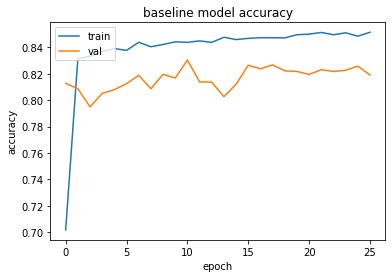

In [38]:
plot_shared(shared_history)

In [39]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model_'+subset+'.h5')
shared.save(trained_model)

C:\Users\mithr\anaconda3\envs\TensorFlow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


##### Load Saved Model and Evaluate

In [40]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model_'+subset+'.h5')
shared_model = load_model(shared_trained_model)

In [41]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
100/100 [==============================] - 2s 8ms/step - loss: 0.3467 - accuracy: 0.8439
test loss, test acc: [0.34671273827552795, 0.8439319729804993]


Classification Report

In [42]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                                                         precision    recall  f1-score   support

                                         W_Assess fraud       0.67      0.55      0.60        29
                            W_Assessing the application       0.75      0.67      0.70      1561
                            W_Calling after sent offers       0.93      0.83      0.88      4773
W_Calling to add missing information to the application       0.85      0.88      0.86      2498
           W_Filling in information for the application       0.79      0.96      0.86      3658
                                 W_Fixing incoming lead       0.68      0.16      0.26       187

                                               accuracy                           0.84     12706
                                              macro avg       0.78      0.67      0.70     12706
                                           weighted avg       0.85      0.84      0.84     12706



Confusion Matrix

[[  16    6    0    3    3    1]
 [   0 1040  139  382    0    0]
 [   0   47 3942    0  784    0]
 [   0  302    2 2194    0    0]
 [   0    0  144    0 3501   13]
 [   8    0    0    0  149   30]]


<AxesSubplot:>

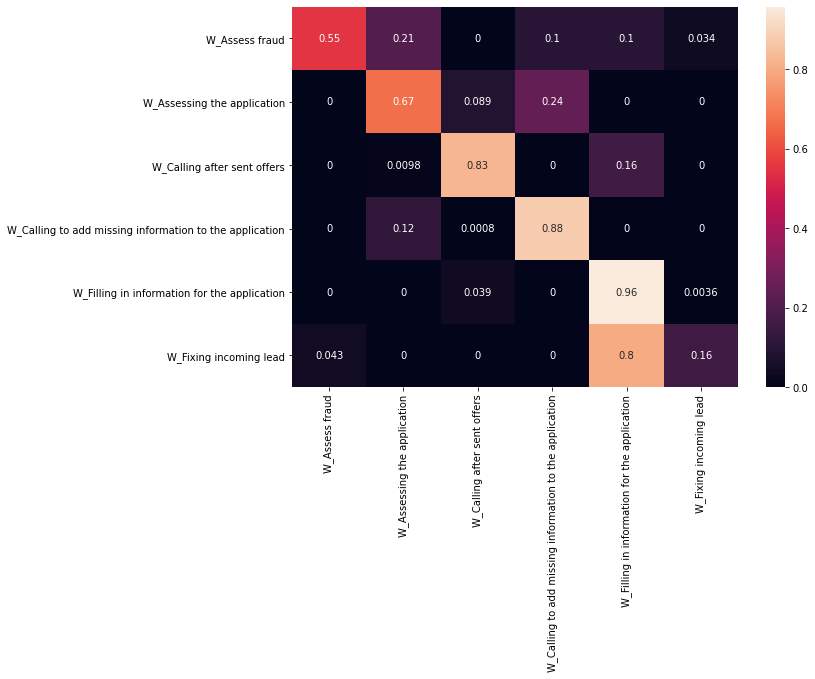

In [43]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

#### specialised Model

In [44]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [45]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [46]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 5, 7)]       0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 5, 58)]      0                                            
__________________________________________________________________________________________________
t_input (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
beta_ac (Bidirectional)         (None, 5, 100)       23200       ac_input[0][0]                   
____________________________________________________________________________________________

In [47]:
batch_size = 256 # 32, 64, 128, 256
epochs = 200

In [48]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/200
99/99 [==============================] - 17s 71ms/step - loss: 1.5721 - accuracy: 0.5409 - val_loss: 1.3816 - val_accuracy: 0.6011
Epoch 2/200
99/99 [==============================] - 3s 33ms/step - loss: 1.2191 - accuracy: 0.6727 - val_loss: 1.1310 - val_accuracy: 0.7029
Epoch 3/200
99/99 [==============================] - 3s 35ms/step - loss: 1.0057 - accuracy: 0.7465 - val_loss: 0.9376 - val_accuracy: 0.7675
Epoch 4/200
99/99 [==============================] - 3s 33ms/step - loss: 0.8805 - accuracy: 0.7611 - val_loss: 0.8382 - val_accuracy: 0.7713
Epoch 5/200
99/99 [==============================] - 3s 33ms/step - loss: 0.8062 - accuracy: 0.7652 - val_loss: 0.7787 - val_accuracy: 0.7733
Epoch 6/200
99/99 [==============================] - 3s 33ms/step - loss: 0.7509 - accuracy: 0.7748 - val_loss: 0.7302 - val_accuracy: 0.7736
Epoch 7/200
99/99 [==============================] - 3s 32ms/step - loss: 0.7119 - accuracy: 0.7841 - val_loss: 0.6945 - val_accuracy: 0.7877
Epoch

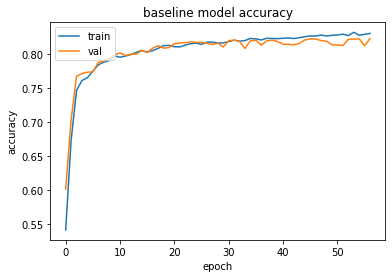

In [49]:
plot_specialised(specialised_history)

In [50]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+subset+'.h5')
specialised.save(trained_model)

C:\Users\mithr\anaconda3\envs\TensorFlow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


##### Load Saved Model and Evaluate

In [51]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model_'+subset+'.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [52]:
# Generating Inputs

x_test,y_test = generate_inputs(vec_test,args,indexes)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test, y_test, batch_size=batch_size)
y_pred = specialised_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
50/50 [==============================] - 3s 12ms/step - loss: 0.3967 - accuracy: 0.8375
test loss, test acc: [0.39670777320861816, 0.8374783396720886]


In [53]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                                                         precision    recall  f1-score   support

                                         W_Assess fraud       0.64      0.55      0.59        29
                            W_Assessing the application       0.78      0.56      0.65      1561
                            W_Calling after sent offers       0.95      0.81      0.87      4773
W_Calling to add missing information to the application       0.80      0.92      0.86      2498
           W_Filling in information for the application       0.78      0.98      0.87      3658
                                 W_Fixing incoming lead       0.70      0.09      0.15       187

                                               accuracy                           0.84     12706
                                              macro avg       0.77      0.65      0.67     12706
                                           weighted avg       0.85      0.84      0.83     12706



Confusion Matrix

[[  16    5    0    3    4    1]
 [   1  869  138  553    0    0]
 [   0   44 3861    3  865    0]
 [   0  195    2 2299    2    0]
 [   0    2   70    0 3580    6]
 [   8    0    0    0  163   16]]


<AxesSubplot:>

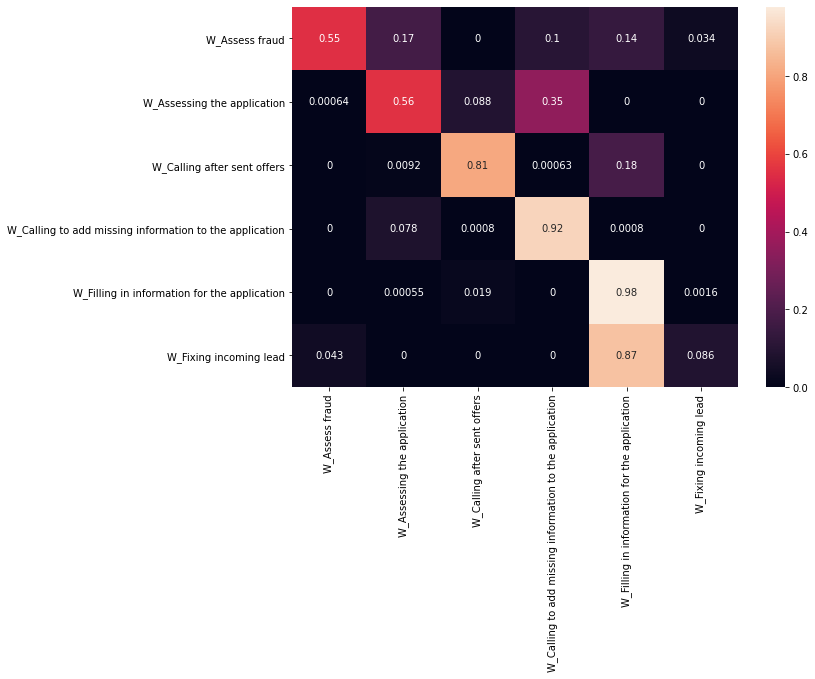

In [54]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)